<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Alzheimer's Image Classification

---
## Problem Statement

Fill this in

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Found GPU at: /device:GPU:0


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall

## Tuned Neural Network

### Train and Test Data

In [20]:
# Create Test and Train 
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.33)

# Data Augmentation referenced from "Deep Learning with Python by Francois Chollet: Chapter 5"
train_datagen_aug = ImageDataGenerator(rescale=1.0/255, 
                                   validation_split=0.33,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = '/content/drive/MyDrive/data/train'
test_dir = '/content/drive/MyDrive/data/test'
img_width = 176
img_height = 208


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

Found 3433 images belonging to 4 classes.
Found 3433 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
train_steps = train_gen.samples // train_gen.batch_size
val_steps = validation_gen.samples // validation_gen.batch_size
print(train_steps)
print(val_steps)

53
26


In [6]:
train_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [7]:
train_gen.image_shape

(208, 176, 3)

Base line accuracy is 50%
Accuracy of basic Neural Net is 56%

### Updated Convolutional Neural Network

In [8]:
# Neural Net architecture referenced from "Deep Learning with Python by Francois Chollet: Chapter 5"

def create_model():
  model = Sequential()
  model.add(Conv2D(
      filters=32,
      kernel_size=(3, 3),
      activation='relu',
      input_shape=(img_height, img_width, 3)
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(
      filters=64,
      kernel_size=(3, 3),
      activation='relu' 
  ))
  model.add(Conv2D(
      filters=64,
      kernel_size=(3, 3),
      activation='relu' 
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(
      filters=128,
      kernel_size=(3, 3),
      activation='relu'
  ))
  model.add(Conv2D(
      filters=128,
      kernel_size=(3, 3),
      activation='relu'
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(
      filters=128,
      kernel_size=(3, 3),
      activation='relu'
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall()])
  return model

Added a new Conv2D, MaxPooling2D, and a dropout layer

In [9]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 206, 174, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 103, 87, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 85, 64)       18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 83, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 39, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 37, 128)       1

In [10]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_gen,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 1982s 37s/step - loss: 1.0810 - accuracy: 0.4752 - precision: 0.5011 - recall: 0.2075 - val_loss: 1.0301 - val_accuracy: 0.5018 - val_precision: 0.5174 - val_recall: 0.4730
Epoch 2/60
53/53 [==============================] - 12s 234ms/step - loss: 0.9742 - accuracy: 0.5381 - precision: 0.6253 - recall: 0.3393 - val_loss: 1.1274 - val_accuracy: 0.3606 - val_precision: 0.6068 - val_recall: 0.1502
Epoch 3/60
53/53 [==============================] - 12s 230ms/step - loss: 0.8377 - accuracy: 0.6275 - precision: 0.6923 - recall: 0.4868 - val_loss: 1.3119 - val_accuracy: 0.3305 - val_precision: 0.3592 - val_recall: 0.2644
Epoch 4/60
53/53 [==============================] - 12s 230ms/step - loss: 0.7687 - accuracy: 0.6566 - precision: 0.7109 - recall: 0.5628 - val_loss: 1.3094 - val_accuracy: 0.3786 - val_precision: 0.4277 - val_recall: 0.3041
Epoch 5/60
53/53 [==============================] - 12s 232ms/step - loss: 0.6529 - accuracy: 0.7201

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs_range = range(60)

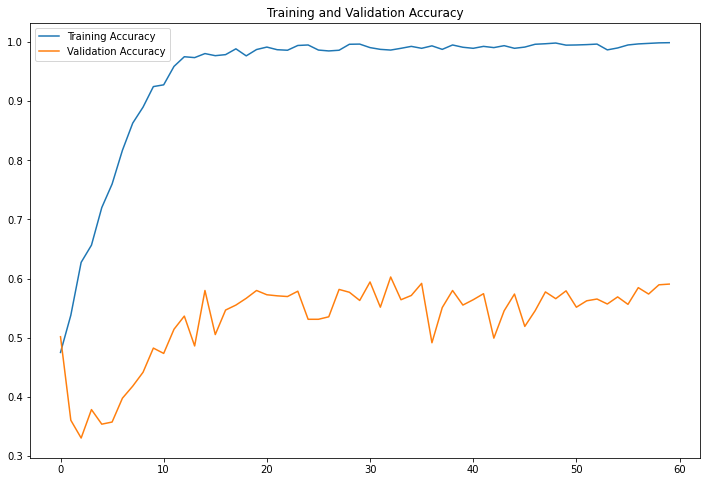

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

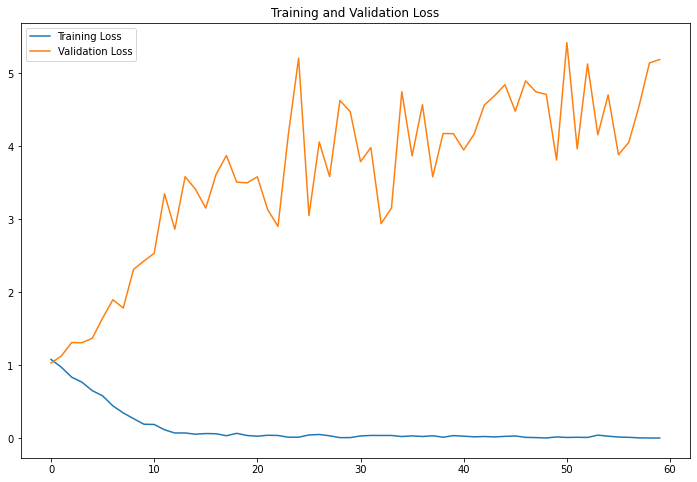

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

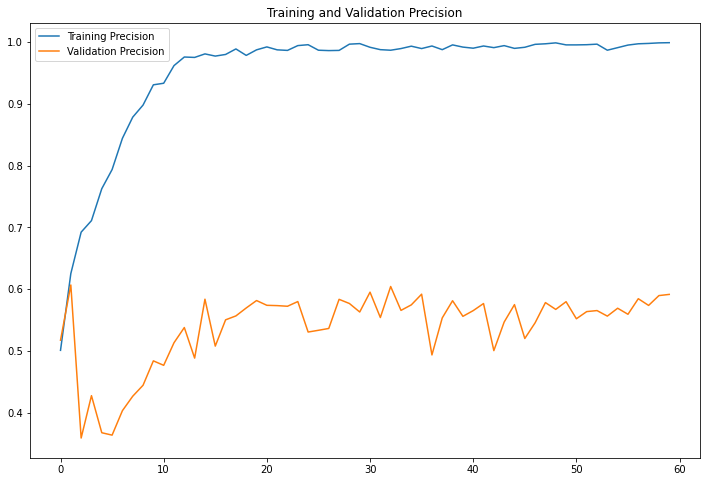

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

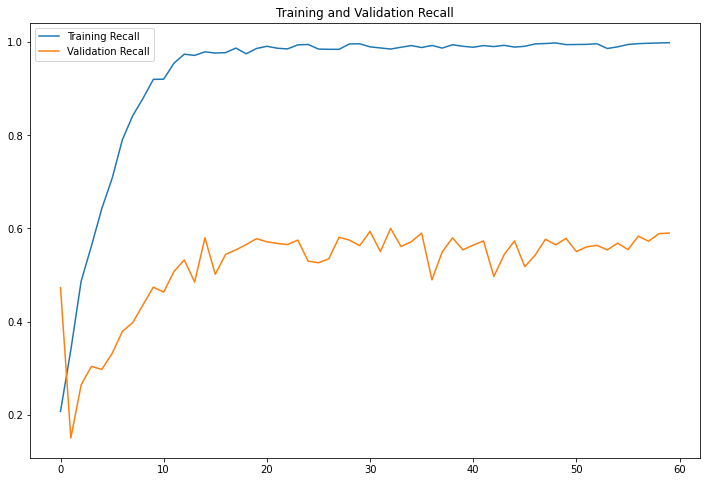

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

Based on all the charts, this updated model is still severly overfit. It is performaning better than our initial basic model. After about 33 epochs the model stops improving. The new best accuracy is about 60%, the best precision is about 60% and best recall score is about 60%.

### Convolutional Neural Network with Data Augmentation

In [23]:
model_aug = create_model()
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 206, 174, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 103, 87, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 101, 85, 64)       18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 99, 83, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 41, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 47, 39, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 45, 37, 128)      

In [24]:
with tf.device('/device:GPU:0'):
  history = model_aug.fit(
      train_gen_aug,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 39s 723ms/step - loss: 1.0807 - accuracy: 0.4874 - precision_2: 0.5150 - recall_2: 0.2291 - val_loss: 1.0501 - val_accuracy: 0.5018 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/60
53/53 [==============================] - 38s 720ms/step - loss: 1.0601 - accuracy: 0.4941 - precision_2: 0.4905 - recall_2: 0.1978 - val_loss: 1.0566 - val_accuracy: 0.5018 - val_precision_2: 0.5018 - val_recall_2: 0.5018
Epoch 3/60
53/53 [==============================] - 38s 716ms/step - loss: 1.0496 - accuracy: 0.4856 - precision_2: 0.4845 - recall_2: 0.1953 - val_loss: 1.0310 - val_accuracy: 0.4982 - val_precision_2: 0.8684 - val_recall_2: 0.0793
Epoch 4/60
53/53 [==============================] - 38s 719ms/step - loss: 1.0434 - accuracy: 0.4930 - precision_2: 0.5136 - recall_2: 0.2458 - val_loss: 1.0332 - val_accuracy: 0.5012 - val_precision_2: 0.5074 - val_recall_2: 0.4946
Epoch 5/60
53/53 [==============================] - 38s 713m

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision_2']
val_prec = history.history['val_precision_2']

recall = history.history['recall_2']
val_recall = history.history['val_recall_2']

epochs_range = range(60)

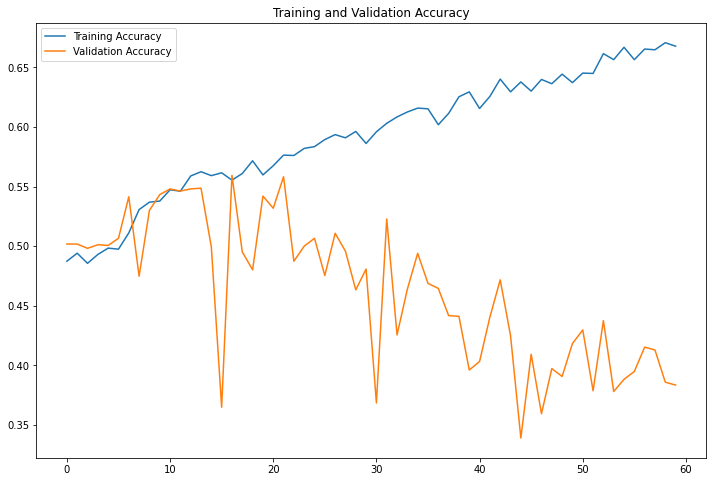

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

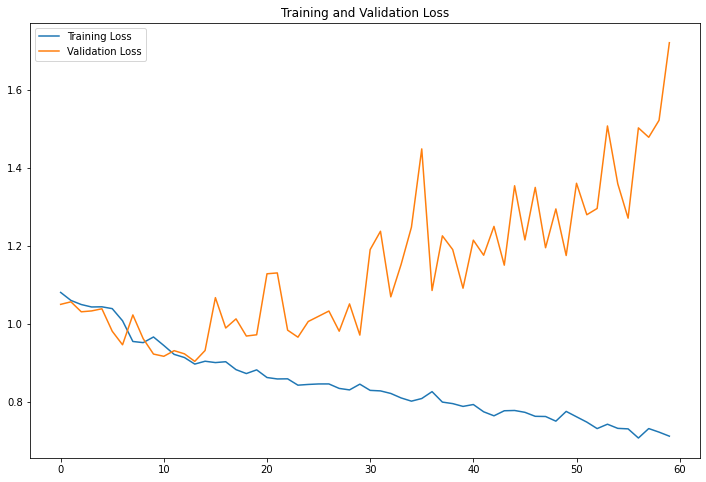

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

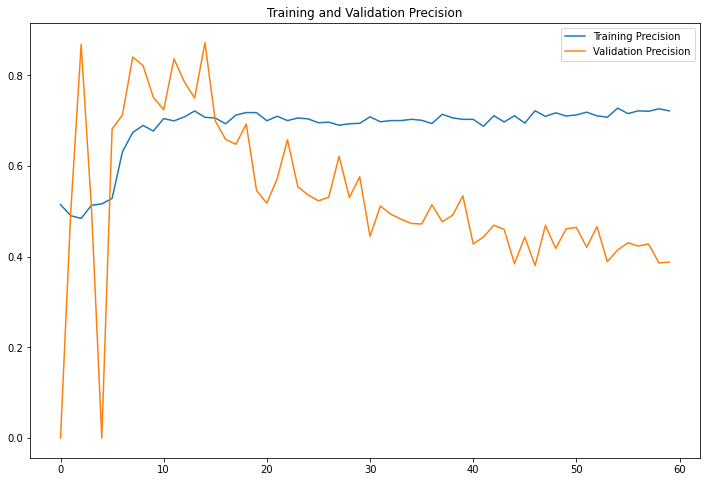

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

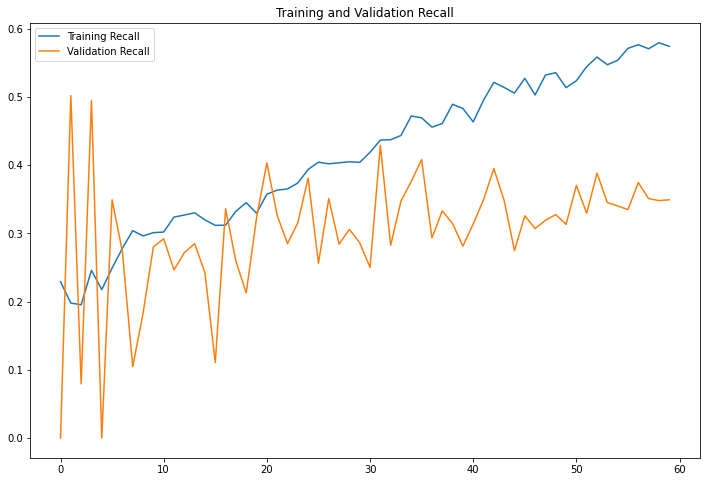

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

After about 15 or so epochs the model stops improving. It is less overfit than our previous model without data augmentation. The best accuracy scores was about 56%, with a best precision of 66% and recall of about 34%. This model overall performs worst than our model without data augmentation. It slightly under performs the previous model.

In [30]:
model.save('/content/drive/MyDrive/project-5/tuned-basic-model.h5')